In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.figsize"] = (40, 5)

from typeguard import typechecked

from numpy import datetime64
from pandas import Timestamp, Timedelta
from datetime import datetime, timedelta
from pvlib import location
from pytz import timezone

from lib.utils import (
    get_irradiance,
    integrate,
    open_forecast_files,
    plot_radiation_and_irradiance,
)
from lib.boat_model import Boat, Panel, Battery, Other, ESC, Motor, Propulsion, Hull
from lib.event_model import (
    Event,
    EventInputData,
    EventResultData,
    EventResultDataSet,
    FixedLapsGoal,
    RaceStatus,
)
from lib.boat_data import (
    BoatInputData,
    BoatInputDataSet,
    BoatOutputData,
    BoatOutputDataSet,
)
from lib.energy_controller_model import EnergyController
from lib.competition_model import Competition


In [2]:
# Create solar dataset
site = location.Location(
    latitude=-22.924247,
    longitude=-43.097405,
    tz="America/Sao_Paulo",
    altitude=0,
    name="Niterói",
)

description = {
    "time": {
        "start": "2022-03-16",
        "end": "2022-03-23",
        "freq": "1min",
    },
}

clearsky_data =  pd.DataFrame(site.get_clearsky(
    pd.date_range(
        start=description["time"]["start"],
        end=description["time"]["end"],
        freq=description["time"]["freq"],
        tz=site.tz,
    )
))

clearsky_data["poa"] = get_irradiance(
    site_location=site,
    tilt=0,
    surface_azimuth=0,
    weather_data=clearsky_data,
)

clearsky_data = clearsky_data[description["time"]["start"] : description["time"]["end"]]

clearsky_data["Solar Energy"] = integrate(clearsky_data, 3600)["poa"]


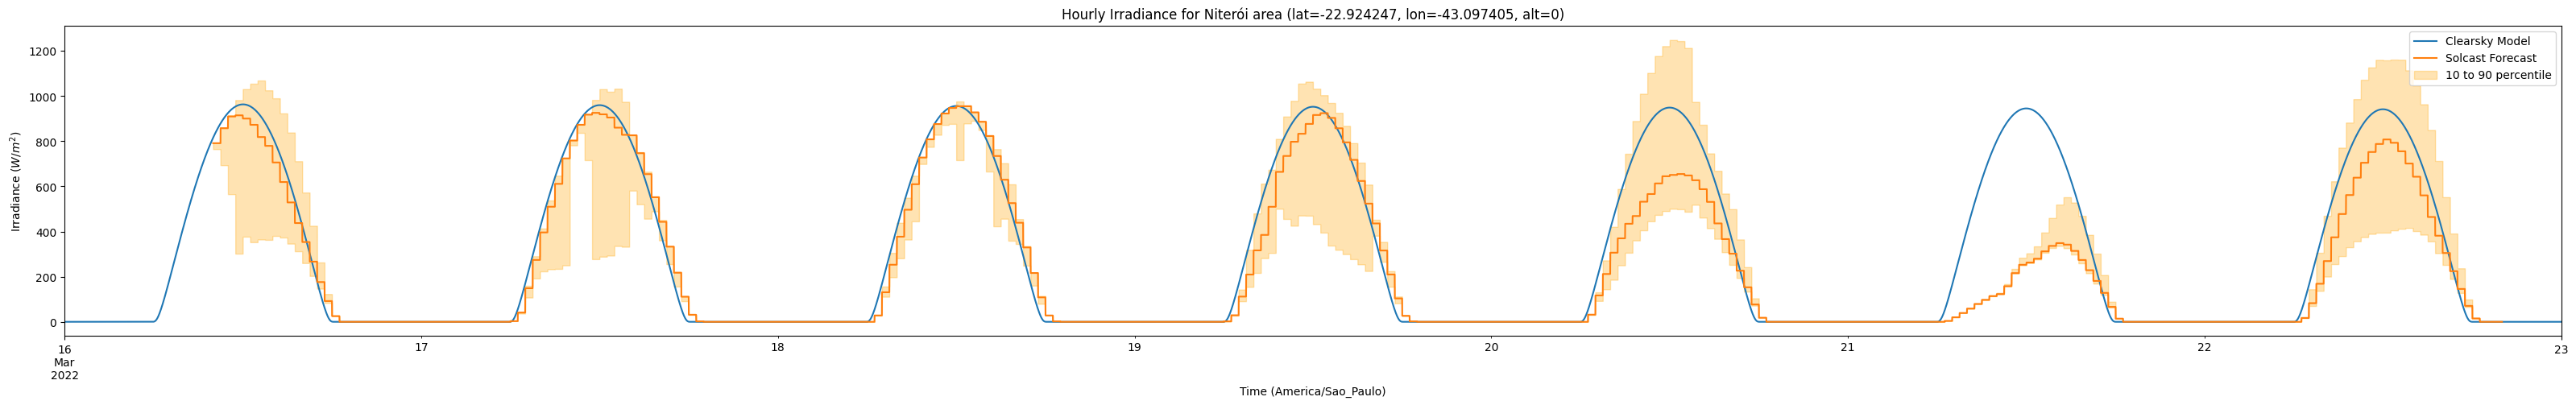

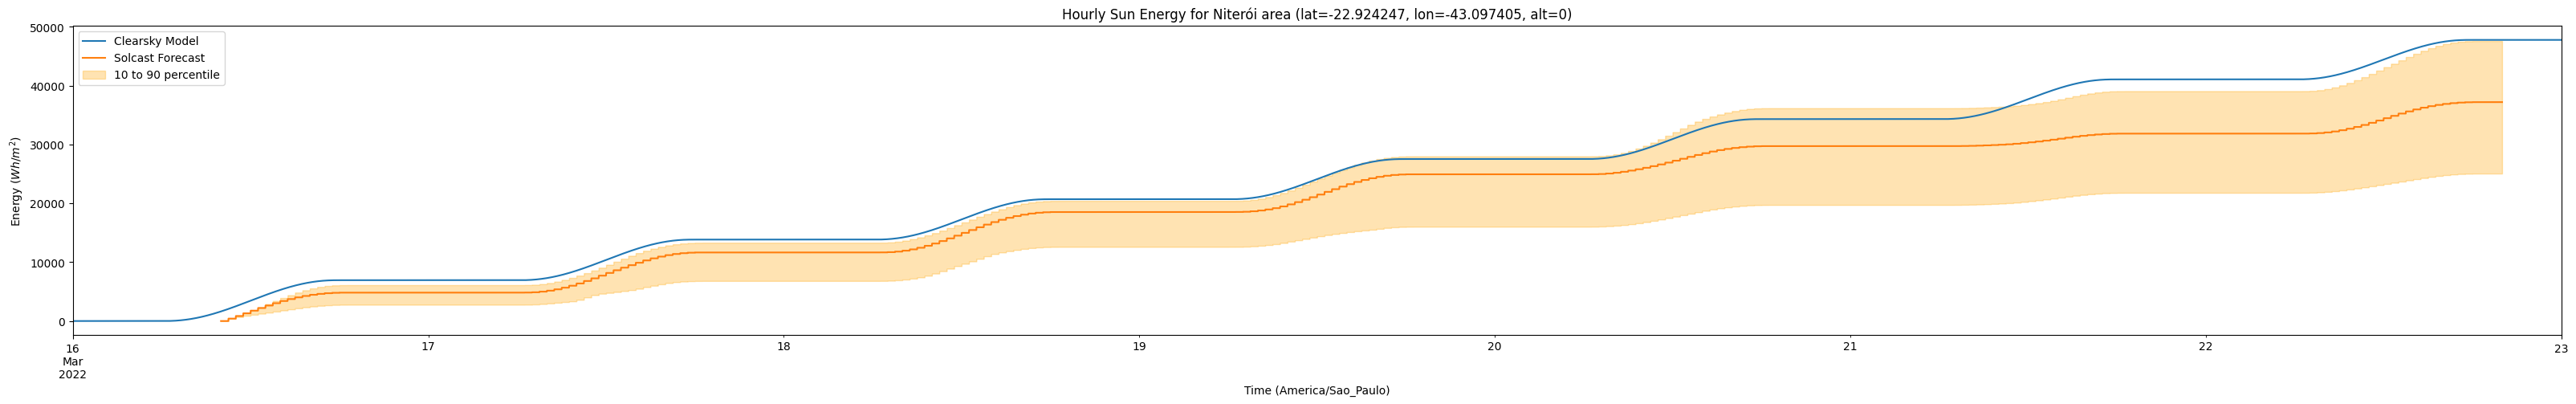

In [5]:
path = "/home/joaoantoniocardoso/ZeniteSolar/2022/Strategy22"

forecast_files = [
    # f"{path}/datasets/solcast_forecast_14032022_1955.csv",
    f"{path}/datasets/solcast_forecast_16032022_0947.csv",
    f"{path}/datasets/solcast_forecast_17032022_0522.csv",
    f"{path}/datasets/solcast_forecast_17032022_0948.csv",
    f"{path}/datasets/solcast_forecast_17032022_1338.csv",
    f"{path}/datasets/solcast_forecast_17032022_1519.csv",
    f"{path}/datasets/solcast_forecast_18032022_0916.csv",
    f"{path}/datasets/solcast_forecast_18032022_1208.csv",
    f"{path}/datasets/solcast_forecast_18032022_1535.csv",
    f"{path}/datasets/solcast_forecast_19032022_0141.csv",
    f"{path}/datasets/solcast_forecast_19032022_0554.csv",
    f"{path}/datasets/solcast_forecast_19032022_0906.csv",
    f"{path}/datasets/solcast_forecast_19032022_1555.csv",
    f"{path}/datasets/solcast_forecast_20032022_0618.csv",
    f"{path}/datasets/solcast_forecast_20032022_1300.csv",
    f"{path}/datasets/solcast_forecast_21032022_0057.csv",
    f"{path}/datasets/solcast_forecast_21032022_1901.csv",
]

real_data = open_forecast_files(forecast_files, description)

real_data.drop(columns=["Period"], inplace=True)
real_data.columns = real_data.columns.str.lower()
real_data.rename(
    columns={"cloudopacity": "Cloud Opacity", "airtemp": "Air Temp"}, inplace=True
)
real_data.index = pd.to_datetime(real_data.index).tz_convert(site.tz)  # type: ignore
freq = pd.infer_freq(real_data.index)
if freq is None:
    raise Exception("Failed infering frequency!")
real_data.index.freq = freq

real_data10 = real_data[["ghi10", "dni10", "dhi"]].rename(
    columns={"ghi10": "ghi", "dni10": "dni"}
)
real_data90 = real_data[["ghi90", "dni90", "dhi"]].rename(
    columns={"ghi90": "ghi", "dni90": "dni"}
)

real_data["poa"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data
)
real_data["poa10"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data10
)
real_data["poa90"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data90
)

real_data = real_data[description["time"]["start"] : description["time"]["end"]]

real_data["Solar Energy"] = integrate(real_data, 3600)["poa"]
real_data["Solar Energy10"] = integrate(real_data, 3600)["poa10"]
real_data["Solar Energy90"] = integrate(real_data, 3600)["poa90"]

real_data = real_data.resample("10s").ffill()

plot_radiation_and_irradiance(clearsky_data, real_data, site)


In [6]:
# Select the input data
from dataclasses import dataclass


input_data = BoatInputDataSet(
    {
        "time": np.array(
            [time.to_datetime64() for time in real_data.index.to_numpy()],
            dtype=datetime64,
        ),
        "poa": real_data["poa"].to_numpy(),
    }
)

# Create the competition
tzinfo = timezone(site.tz)
competition = Competition(
    name="DSB 2022 - Etapa Niterói",
    events=[
        Event(
            EventInputData(
                name="Match Race Qualifiers",
                description="Classificatórias da prova 1x1",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=786.73,
                    total_time=Timedelta(timedelta(hours=1)),
                ),
                start=Timestamp(datetime(2022, 3, 17, 9, 30, tzinfo=tzinfo)),
                end=Timestamp(datetime(2022, 3, 17, 10, 30, tzinfo=tzinfo)),
            )
        ),
        # Event(
        #     EventInputData(
        #         name="Match Race",
        #         description="Prova 1x1",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=786.73,
        #             total_time=Timedelta(timedelta(hours=2)),
        #         ),
        #         start=Timestamp(datetime(2022, 3, 17, 14, 00, tzinfo=tzinfo)),
        #         end=Timestamp(datetime(2022, 3, 17, 16, 00, tzinfo=tzinfo)),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Long Race 1",
        #         description="Prova longa",
        #         goal=FixedLapsGoal(
        #             total_laps=3,
        #             lap_distance=7081.987,
        #             total_time=Timedelta(timedelta(hours=5)),
        #         ),
        #         start=Timestamp(datetime(2022, 3, 18, 11, 00, tzinfo=tzinfo)),
        #         end=Timestamp(datetime(2022, 3, 18, 16, 00, tzinfo=tzinfo)),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Relay Race",
        #         description="Prova de revezamento de pilotos",
        #         goal=FixedLapsGoal(
        #             total_laps=2,
        #             lap_distance=812.19,
        #             total_time=Timedelta(timedelta(hours=3)),
        #         ),
        #         start=Timestamp(datetime(2022, 3, 19, 9, 30, tzinfo=tzinfo)),
        #         end=Timestamp(datetime(2022, 3, 19, 12, 30, tzinfo=tzinfo)),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Short Race 1",
        #         description="Prova curta",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=4678.39,
        #             total_time=Timedelta(timedelta(hours=2)),
        #         ),
        #         start=Timestamp(datetime(2022, 3, 20, 11, 30, tzinfo=tzinfo)),
        #         end=Timestamp(datetime(2022, 3, 20, 13, 30, tzinfo=tzinfo)),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Quick Race 1",
        #         description="Prova rápida",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=4678.39,
        #             total_time=Timedelta(timedelta(hours=1)),
        #         ),
        #         start=Timestamp(datetime(2022, 3, 20, 9, 30, tzinfo=tzinfo)),
        #         end=Timestamp(datetime(2022, 3, 20, 10, 30, tzinfo=tzinfo)),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Sprint Race",
        #         description="Prova de arrancada",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=1057.03,
        #             total_time=Timedelta(timedelta(hours=1.5)),
        #         ),
        #         start=Timestamp(datetime(2022, 3, 22, 10, 30, tzinfo=tzinfo)),
        #         end=Timestamp(datetime(2022, 3, 22, 12, 00, tzinfo=tzinfo)),
        #     )
        # ),
    ],
)


# Create the boat
boat = Boat(
    panel=Panel(efficiency=0.16, maximum_output_power=(4 * 300), area=(4 * 1.6 * 1.0)),
    battery=Battery(
        efficiency=0.8,
        soc_0=0.95,
        minimum_soc=0.05,
        maximum_energy=1500,
        maximum_power=10000,
    ),
    circuits=Other(power=(18 * 3.0)),
    esc=ESC(
        efficiency=0.85,
        maximum_input_power=5000,
    ),
    motor=Motor(efficiency=0.85, maximum_input_power=5000),
    propulsion=Propulsion(
        efficiency=0.7,
        maximum_input_power=10000,
    ),
    hull=Hull(speed_over_power_constant=(18.0 / 3.6) / 3000.0),
)

from strictly_typed_pandas.dataset import DataSet


@dataclass
class PredictionData:
    time: datetime64
    poa: float
    poa10: float
    poa90: float


PredictionDataSet = DataSet[PredictionData]


In [7]:

# Create the energy controller
@typechecked
class AverageController(EnergyController):
    def __init__(self, prediction_dataset: PredictionDataSet, overdrive: float):
        self.overdrive: float = overdrive
        self.prediction_dataset: PredictionDataSet = prediction_dataset
        self.event_power: float = 0.0
        self.event_name: str = ""

    def run(
        self,
        dt: float,
        input_data: BoatInputData,
        output_data: BoatOutputData,
        event_result: EventResultData,
        boat: Boat,
        event: EventInputData,
    ) -> float:
        if event_result.status != RaceStatus.STARTED:
            return 0.0

        # For each event, use all the available energy
        if self.event_name != event.name:
            self.event_name = event.name
            start = event.start.tz_localize(None)
            end = event.end.tz_localize(None)
            pred_competition_df = self.prediction_dataset.to_dataframe().set_index("time")
            pred_event_df = pred_competition_df.loc[start:end]
            pred_event_poa_avg = pred_event_df.mean()

            event_solar_energy = integrate(pred_event_df)['poa'].to_numpy()[-1]
            event_duration = (end - start).to_numpy().astype(np.int64) * 1e-9 / 3600.0 # in hours

            event_solar_avg_poa = event_solar_energy / event_duration
            event_solar_avg_power = boat.panel.solve_output(irradiation=event_solar_avg_poa)
            event_battery_avg_power = float((boat.battery.energy - boat.battery.minimum_energy) * boat.battery.efficiency / event_duration)
            event_battery_avg_power = min(event_battery_avg_power, boat.battery.maximum_power)

            self.event_power = event_solar_avg_power + event_battery_avg_power

        p_motor = boat.motor.solve_input(self.event_power)
        throttle = p_motor / boat.motor.maximum_input_power

        return throttle * self.overdrive


energy_controller = AverageController(
    prediction_dataset=PredictionDataSet(
        {
            "time": np.array(
                [time.to_datetime64() for time in real_data.index.to_numpy()],
                dtype=datetime64,
            ),
            "poa": real_data.poa.to_numpy(),
            "poa10": real_data.poa10.to_numpy(),
            "poa90": real_data.poa90.to_numpy(),
        }
    ),
    overdrive=1,
)

# Run the simulation
competition_result = competition.run(
    input_data=input_data, boat=boat, energy_controller=energy_controller
)


Boat out of the race, status: STARTED => DNF. Reason: ("Time over: 0 days 01:03:00 > 0 days 01:00:00\n FixedLapsGoal(total_laps=1, lap_distance=786.73, total_time=Timedelta('0 days 01:00:00'), _completed_laps=0)\n EventResultData(distance=273.7072914904063, elapsed_time=numpy.timedelta64(3780000000000,'ns'), status=1)",)


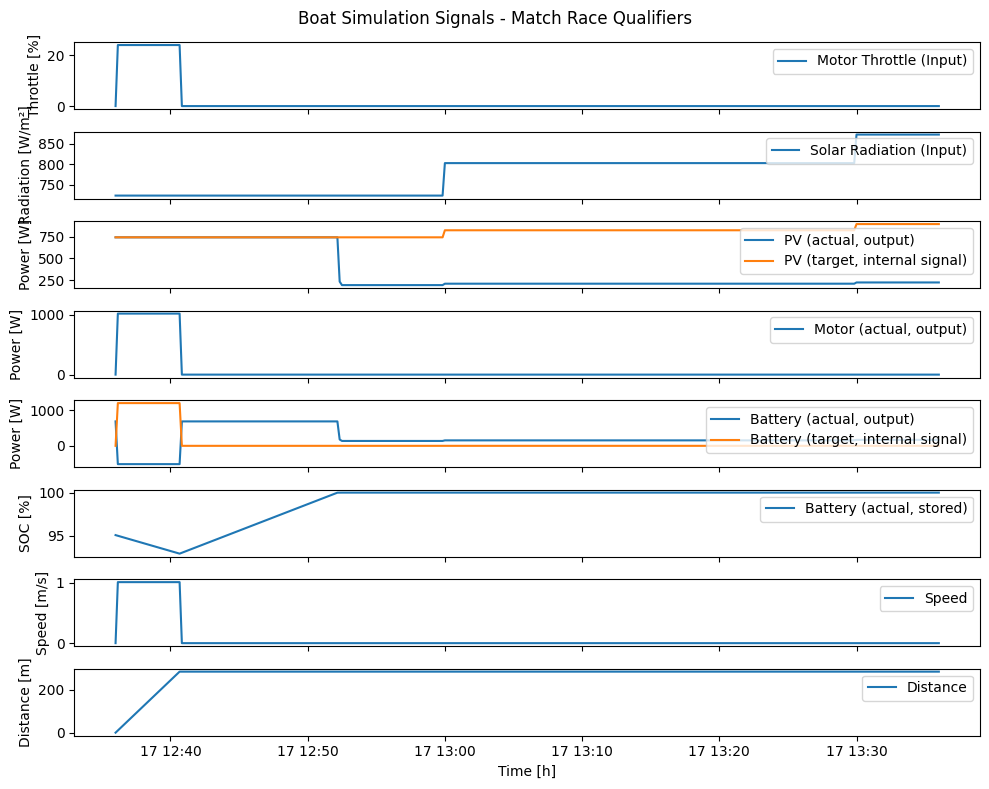

In [8]:
# Plot the simulation

for result in competition_result.results:

    fig, axs = plt.subplots(8, figsize=(10, 8 * 1.0), sharex=True, sharey=False)

    axs[0].plot(
        result.input_data.time,
        result.output_data.motor_target_throttle * 100,
        label="Motor Throttle (Input)",
    )
    axs[0].legend(loc="upper right")
    axs[0].set_ylabel("Throttle [%]")

    axs[1].plot(
        result.input_data.time,
        result.input_data.poa,
        label="Solar Radiation (Input)",
    )
    axs[1].legend(loc="upper right")
    axs[1].set_ylabel("Radiation [W/m²]")

    axs[2].plot(
        result.input_data.time,
        result.output_data.pv_output_power,
        label="PV (actual, output)",
    )
    axs[2].plot(
        result.input_data.time,
        result.output_data.pv_target_power,
        label="PV (target, internal signal)",
    )
    axs[2].legend(loc="upper right")
    axs[2].set_ylabel("Power [W]")

    axs[3].plot(
        result.input_data.time,
        result.output_data.motor_output_power,
        label="Motor (actual, output)",
    )
    # axs[3].plot(
    #     result.input_data.time,
    #     result.output_data.motor_target_power,
    #     label="Motor (target, internal signal)",
    # )
    axs[3].legend(loc="upper right")
    axs[3].set_ylabel("Power [W]")

    axs[4].plot(
        result.input_data.time,
        result.output_data.battery_output_power,
        label="Battery (actual, output)",
    )
    axs[4].plot(
        result.input_data.time,
        result.output_data.battery_target_power,
        label="Battery (target, internal signal)",
    )
    axs[4].legend(loc="upper right")
    axs[4].set_ylabel("Power [W]")

    axs[5].plot(
        result.input_data.time,
        result.output_data.battery_soc * 100,
        label="Battery (actual, stored)",
    )
    axs[5].legend(loc="upper right")
    axs[5].set_ylabel("SOC [%]")

    axs[6].plot(
        result.input_data.time,
        result.output_data.hull_speed,
        label="Speed",
    )
    axs[6].legend(loc="upper right")
    axs[6].set_ylabel("Speed [m/s]")

    axs[7].plot(
        result.input_data.time,
        result.event_result.distance,
        label="Distance",
    )
    axs[7].legend(loc="upper right")
    axs[7].set_ylabel("Distance [m]")

    plt.xlabel("Time [h]")
    plt.suptitle(f"Boat Simulation Signals - {result.name}")
    plt.tight_layout()
    plt.show()
